In [1]:
from model import *
from utils import binMolDen
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from random import sample
from sklearn import metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.utils.data import dataset, DataLoader
# from torch.utils.tensorboard import SummaryWriter

In [2]:
# writer = SummaryWriter(log_dir='train/log/toy')
# data = pd.read_csv('data/train.csv', header=None, index_col=None).to_numpy()
data = np.load('data/train.npz')['data']
train_data, valid_data= split_data(
        data, valid_ratio = 0.00,
        randomSeed = 2022
)
test_data = np.load('data/test.npz')['data']
print(len(test_data))
print('Test size =', len(test_data))

train_dataset = IonDataset(data = train_data)
valid_dataset = IonDataset(data = valid_data)
test_dataset = IonDataset(data = test_data)

train_loader = DataLoader(
    train_dataset, batch_size=1024, num_workers=0, drop_last=False, 
    shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=1024, num_workers=0, drop_last=False, 
    shuffle=False
)

test_loader = DataLoader(
    test_dataset, batch_size=1024, num_workers=0, drop_last=False, 
    shuffle=False
)

The random seed is:  2022
Train size: 2400000, Validation size: 0
1050000
Test size = 1050000


In [3]:
criterion = nn.MSELoss()
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
model = IonNet(n_in=6, activation='ReLU').to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.005)
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.1)

model_checkpoints_folder = os.path.join('train/', 'NN')

n_epochs=100
log_every = 500
# log_every = len(train_loader)
n_iter = 0
valid_n_iter = 0
best_valid_loss = np.inf
best_valid_mae = np.inf
best_valid_roc_auc = 0

for epoch_counter in range(n_epochs):
    model.train()
    for bn, (inputs, target) in enumerate(train_loader):

        input_var = inputs.to(device)
        target = target.to(device)
        # compute output
        optimizer.zero_grad()
        output = model(input_var)

        loss = criterion(output, target)



        if bn % log_every == 0:
            # writer.add_scalar('train_loss', loss.item(), global_step=n_iter)
            print('Epoch: %d, Batch: %d, Loss:'%(epoch_counter+1, bn), loss.item())        
        loss.backward()
        optimizer.step()
        n_iter += 1
    scheduler.step()

    # validate the model if requested
    if epoch_counter % 1 == 0:
        losses = AverageMeter()
        mae_errors = AverageMeter()
        with torch.no_grad():
            model.eval()
            for bn, (inputs, target) in enumerate(valid_loader):
                input_var = inputs.to(device)
                target = target.to(device)
                # compute output
                output = model(input_var)
                loss = criterion(output, target)
                mae_error = mae(output, target)
                mae_errors.update(mae_error, target.size(0))

            print('Epoch [{0}] Validate: [{1}/{2}], '
                    'MAE {mae_errors.val:.3f} ({mae_errors.avg:.3f})'.format(
                epoch_counter+1, bn+1, len(valid_loader),
                mae_errors=mae_errors))

        if mae_errors.avg < best_valid_mae:
            # save the model weights
            best_valid_mae = mae_errors.avg
            torch.save(model.state_dict(), os.path.join(model_checkpoints_folder, 'model.pth'))

        # writer.add_scalar('valid_loss', losses.avg, global_step=valid_n_iter)
        valid_n_iter += 1


Epoch: 1, Batch: 0, Loss: 0.3192266821861267
Epoch: 1, Batch: 500, Loss: 0.00508582079783082
Epoch: 1, Batch: 1000, Loss: 0.0022013604175299406
Epoch: 1, Batch: 1500, Loss: 0.0029246043413877487
Epoch: 1, Batch: 2000, Loss: 0.0022714361548423767
Epoch [1] Validate: [1026/1026], MAE 0.028 (0.028)
Epoch: 2, Batch: 0, Loss: 0.002813566941767931
Epoch: 2, Batch: 500, Loss: 0.0007927943952381611
Epoch: 2, Batch: 1000, Loss: 0.005917117930948734
Epoch: 2, Batch: 1500, Loss: 0.0015904931351542473
Epoch: 2, Batch: 2000, Loss: 0.00129710475448519
Epoch [2] Validate: [1026/1026], MAE 0.018 (0.017)
Epoch: 3, Batch: 0, Loss: 0.0008751788991503417
Epoch: 3, Batch: 500, Loss: 0.00043208023998886347
Epoch: 3, Batch: 1000, Loss: 0.0019041028572246432
Epoch: 3, Batch: 1500, Loss: 0.0020956029184162617
Epoch: 3, Batch: 2000, Loss: 0.0005431307945400476
Epoch [3] Validate: [1026/1026], MAE 0.007 (0.016)
Epoch: 4, Batch: 0, Loss: 0.0007298844284377992
Epoch: 4, Batch: 500, Loss: 0.0006512182299047709
Epoc

In [4]:
state_dict = torch.load(os.path.join(model_checkpoints_folder, 'model.pth'), map_location=device)
model.load_state_dict(state_dict)

mae_errors = AverageMeter()
with torch.no_grad():
    model.eval()
    for bn, (inputs, target) in enumerate(test_loader):
        input_var = inputs.to(device)
        target = target.to(device)
        # compute output
        output = model(input_var)
        mae_error = mae(output.data, target)
        mae_errors.update(mae_error, target.size(0))

    print('Epoch [{0}] Test: [{1}/{2}], '
            'MAE: {mae_errors.avg:.3f}'.format(
        epoch_counter+1, bn+1, len(test_loader),
        mae_errors=mae_errors))


Epoch [100] Test: [1026/1026], MAE: 0.011


In [5]:
# bins = np.linspace(0, 1.9+0.2, 100)
gap=2.0
binSize=0.02
bins = np.array([i*binSize for i in range(int((gap/2+0.1)//binSize))])

with torch.no_grad():
    model.eval()
    cdf = []
    for b in bins:
        p = model(torch.tensor([b, gap, 2.2, 4.8305, 0.0128, -1]).float().to(device)).cpu().numpy()
        cdf.append(p)
    cdf = np.array(cdf)
    pdf = cdf[1:]-cdf[:-1]
    # conc_profile = binMolDen(3.1928623, 3.4032, binSize, pdf*len(ions)/2)

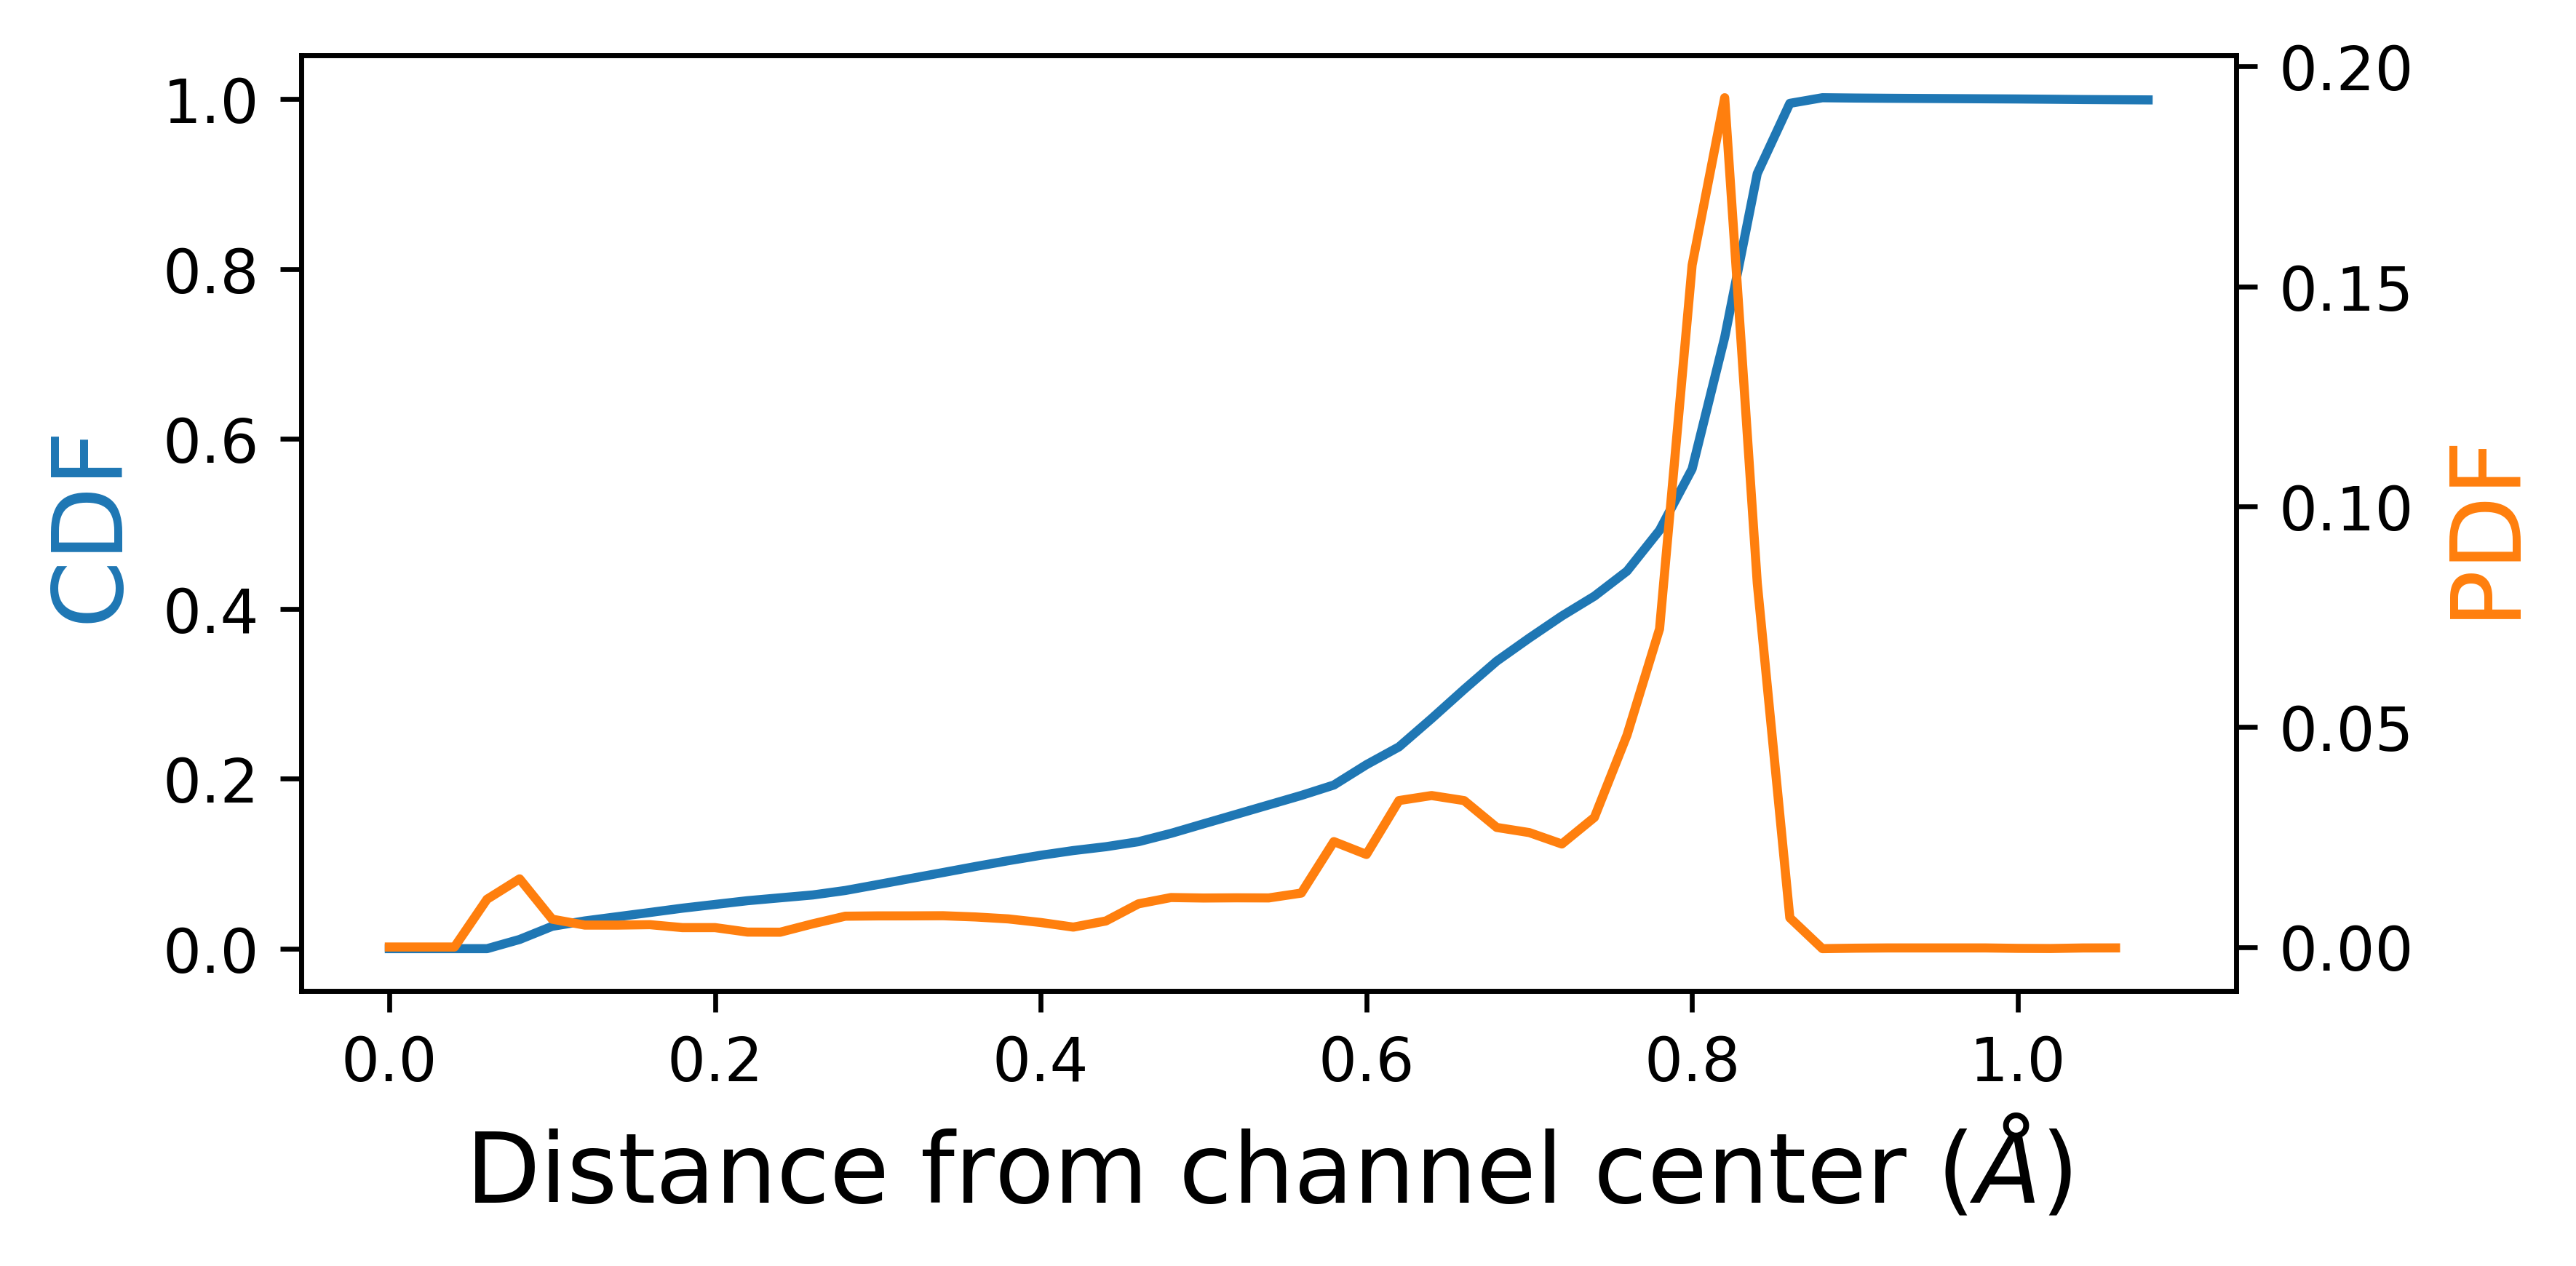

In [6]:
fig, ax = plt.subplots(figsize = (6, 3), dpi=600)
ax2 = ax.twinx()
ax.plot(bins, cdf, color = 'C0')
ax2.plot(bins[:-1], pdf, color = 'C1')
 
# giving labels to the axises
ax.set_xlabel('Distance from channel center ($\AA$)', fontsize=16)
ax.set_ylabel('CDF', color = 'C0', fontsize=16)
ax2.set_ylabel('PDF', color = 'C1', fontsize=16)
 
# defining display layout
plt.tight_layout()
